# Build an MLP from scracth
Follow the steps from: https://medium.com/@mn05052002/building-a-simple-mlp-from-scratch-using-pytorch-7d50ca66512b

## Imports

In [1]:
import logging
import sys

from dotenv import load_dotenv

import matplotlib.pyplot as plt

import numpy as np

import seaborn as sns


# LOGGER
logger = logging.getLogger()
logging.basicConfig(
    stream=sys.stdout,
    level=logging.INFO,
    format='%(asctime)s %(message)s',
    datefmt='%Y-%m-%y %H:%M:%S',
)


# MODULE RELOAD
%load_ext autoreload
%autoreload 2


# Load dotenv
_ = load_dotenv()

In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


## Generate training data

In [3]:
from torch.utils.data import DataLoader, TensorDataset

# Generate dataset
X, y = make_moons(n_samples=5000, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
# X_train = torch.tensor(X_train, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
# X_test = torch.tensor(X_test, dtype=torch.float32)
# y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)


# Create data_loaders
train_data = DataLoader(
    TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32)
    ),
    batch_size=64,
    shuffle=True,
)
test_data = DataLoader(
    TensorDataset(
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.float32)
    ),
    batch_size=64,
    shuffle=True,
)

<Axes: >

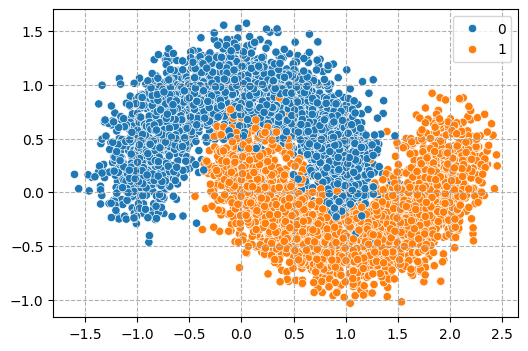

In [4]:
_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=y,
    hue_order=[0, 1],
    
)

## Define simple MLP

In [5]:
class BasicMLP(nn.Module):
    """My Basic MLP"""

    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
    ):
        super(BasicMLP, self).__init__()
        # Set up layers manually
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

        # Intermediate and final activation layers
        self.relu = F.relu
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Apply layer
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))

        x = self.sigmoid(x)

        return x

## Train model

### Set up model

In [6]:
model = BasicMLP(
    input_size=2,
    hidden_size=64,
    output_size=1,
)

### Define trainer

In [7]:
from typing import Callable

from torch.optim import Optimizer


def train(
    data: DataLoader,
    loss_fn: Callable[[torch.tensor], float],
    optimizer: Optimizer
) -> None:
    """Do training"""
    for n, batch in enumerate(data):
        
        if n % 100 == 0:
            logger.info(f'Training batch {n} (of {len(data)})')
        # Get data
        X, y = batch

        # Zero the gradients
        optimizer.zero_grad()

        # Get the predictions
        y_hat = model(X)

        # Cmpute the loss
        loss = loss_fn(y_hat.squeeze(), y)

        # Propagate
        loss.backward()

        # Adjust params
        optimizer.step()


def test(
    data: DataLoader,
    model: nn.Module,
    prob: float = 0.5
) -> None:
    """Test model performance."""

    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data:
            X, y = batch
            # y_hat = model(X).round().squeeze()
            y_hat = model(X).squeeze()
            y_hat = (prob < y_hat).float()

            total += y.size(0)
            correct += (y_hat == y).sum().item()

    accuracy = 100 * correct / total
    logger.info(f'Accuracy on {total} samples: {accuracy:.2f}%')

    return correct, total


In [8]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [9]:
n_epochs = 20
for epoch in range(n_epochs):
    if epoch % 5 == 0:
        logger.info(
            f'Starting training epoch {epoch + 1:2d} of {n_epochs:2d}'
        )

    # Train loop
    train(train_data, loss_fn=loss_fn, optimizer=optimizer)

    # Test loop
    test(test_data, model=model)

2025-09-25 22:36:45 Starting training epoch  1 of 20
2025-09-25 22:36:45 Training batch 0 (of 63)
2025-09-25 22:36:48 Accuracy on 1000 samples: 85.60%
2025-09-25 22:36:48 Training batch 0 (of 63)
2025-09-25 22:36:48 Accuracy on 1000 samples: 87.80%
2025-09-25 22:36:48 Training batch 0 (of 63)
2025-09-25 22:36:48 Accuracy on 1000 samples: 88.40%
2025-09-25 22:36:48 Training batch 0 (of 63)
2025-09-25 22:36:48 Accuracy on 1000 samples: 89.20%
2025-09-25 22:36:48 Training batch 0 (of 63)
2025-09-25 22:36:48 Accuracy on 1000 samples: 89.30%
2025-09-25 22:36:48 Starting training epoch  6 of 20
2025-09-25 22:36:48 Training batch 0 (of 63)
2025-09-25 22:36:48 Accuracy on 1000 samples: 89.80%
2025-09-25 22:36:48 Training batch 0 (of 63)
2025-09-25 22:36:48 Accuracy on 1000 samples: 90.40%
2025-09-25 22:36:48 Training batch 0 (of 63)
2025-09-25 22:36:48 Accuracy on 1000 samples: 90.80%
2025-09-25 22:36:48 Training batch 0 (of 63)
2025-09-25 22:36:48 Accuracy on 1000 samples: 91.30%
2025-09-25 2

In [10]:
X, y_true, y_pred = [], [], []
with torch.no_grad():
    for data in test_data:
        x, y_ = data
        y_hat = model(x).squeeze()
        y_hat = (.5 < y_hat).float()

        # Store
        X.append(x)
        y_true.append(y_)
        y_pred.append(y_hat)

X = torch.concat(X).numpy()
y_true = torch.concat(y_true).numpy()
y_pred = torch.concat(y_pred).numpy()

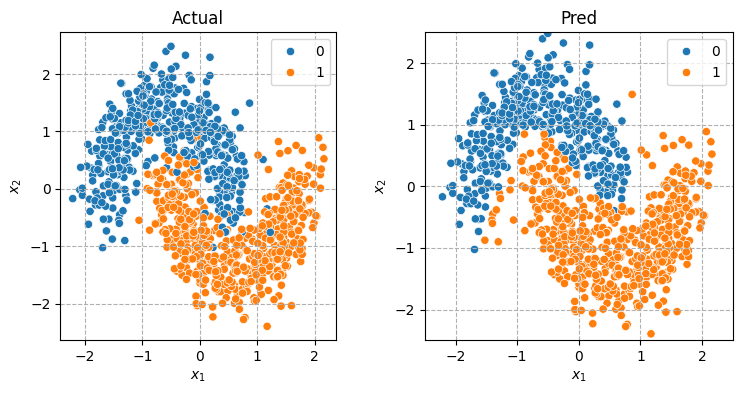

In [11]:
_, (left, right) = plt.subplots(1, 2, figsize=(9, 4))
left.grid(ls='--')
right.grid(ls='--')

sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=y_true,
    hue_order=[0, 1],
    ax=left   
)

left.set(
    title='Actual',
    xlabel=r'$x_{1}$',
    ylabel=r'$x_{2}$',
    aspect='equal',
);

sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=y_pred,
    hue_order=[0, 1],
    ax=right   
)

right.set(
    title='Pred',
    xlim=(-2.5, 2.5),
    ylim=(-2.5, 2.5),
    xlabel=r'$x_{1}$',
    ylabel=r'$x_{2}$',
    aspect='equal',
);

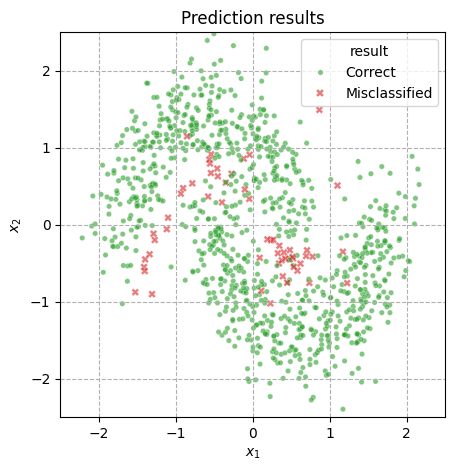

In [13]:
import pandas as pd

data = (
    pd.DataFrame(
        data=np.stack(
            [
                X[:, 0],
                X[:, 1],
                y_true,
                y_pred,
                y_pred == y_true,
            ],
            axis=1
        ),
        columns=['x1', 'x2', 'true', 'pred', 'result']
    )
    .pipe(lambda df: (
        df.assign(**{
            'result': (
                df['result']
                .astype(np.bool_)
                .map({
                    True: 'Correct',
                    False: 'Misclassified',
                })
            )
        })
    ))
)
data


_, ax = plt.subplots(figsize=(5, 5))
ax.grid(ls='--')

sns.scatterplot(
    data=data,
    x='x1',
    y='x2',
    hue='result',
    hue_order=['Correct', 'Misclassified'],
    palette=['tab:green', 'tab:red'],
    size='result',
    sizes=[15, 30],
    style='result',
    markers=['o', 'X'],
    alpha=.6,
)

ax.set(
    title='Prediction results',
    xlim=(-2.5, 2.5),
    ylim=(-2.5, 2.5),
    xlabel=r'$x_{1}$',
    ylabel=r'$x_{2}$',
    aspect='equal',
);